In [ ]:
from tqdm import tqdm
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

###SCM of the Cancer DTR under policy intervention

In [ ]:
# global policy mapping tensors

NO_OF_POLICIES = (2**2) * (2**(2*3))

h_tensor = np.array([[0,0],
                     [0,1],
                     [1,0],
                     [1,1]])

i_tensor = np.zeros((64,2,3))
for pol in range(64):
  temp = pol
  digits = np.zeros((6,))
  for i in range(6):
    digits[5-i] = temp%2
    temp = int(temp/2)
  digits = np.reshape(digits,newshape=(2,3))
  i_tensor[pol] = digits

# global transition probabilities

f_tensor = np.array([[[0.3559, 0.4546, 0.2677],[0.5406, 0.3854, 0.6974]],
                     [[0.3759, 0.3707, 0.3845],[0.5919, 0.6303, 0.5276]]])


def cancer_dtr(pi = None):
  '''
  Runs an instance of the cancer DTR, under intervention using a policy pi

  INPUT
  pi (int, 0-255): the policy index of the intervention

  OUTPUT
  g (int, 0-1): value of G for one instance under pi
  h (int, 0-1): value of H for one instance under pi
  c (int, 0-2): value of C for one instance under pi
  i (int, 0-1): value of I for one instance under pi
  f (int, 0-1): value of F for one instance under pi
  '''

  if pi not in np.arange(NO_OF_POLICIES):
    print("ERROR: pi should be an integer from 0-255")
    return
  
  # getting g
  g = bernoulli.rvs(p=0.7454)

  # mapping pi to get h
  pi_h = int(pi/64)
  h = h_tensor[pi_h][g]

  # getting c
  if h == 0:
    c = np.random.multinomial(1,[0.4055,0.2904,0.3041]) @ np.array([0,1,2])
  else:
    c = np.random.multinomial(1,[0.3051,0.4081,0.2868]) @ np.array([0,1,2])

  # mapping pi to get i
  pi_i = pi%64
  i = i_tensor[pi_i][g][c]
  i = int(i)

  # getting f
  f = bernoulli.rvs(p = f_tensor[h][i][c])

  return g,h,c,i,f

### Naive EXP3 Algorithm

In [ ]:
def naive_exp3(T = 500, eta = None):
  '''
  Plays Naive EXP3 for T episodes, with 100 overall runs

  INPUT:
  T (int, >=500): number of episodes; default 500
  eta (float, > 0): learning rate; default 1/T

  OUTPUT:
  regret: array of reget every 500 episodes, averaged over 100 runs
  cumulative_regret: array of cumulative regret every 500 episodes, avg. over 100 runs
  reward: array of reward every 500 episodes, avg. over 100 runs
  '''
 
  # initializations

  if T < 500:
    print("ERROR: T needs to be at least 500")
    return
  if eta == None:
    eta = 1/T
  if eta <= 0.0:
    print("ERROR: eta needs to be > 0.0") 
  RUNS = 100
  step = 500
  data_points = int(T/step)+1
  regret = np.zeros((RUNS,data_points))
  cumulative_regret = np.zeros((RUNS,data_points))
  reward = np.zeros((RUNS,data_points))

  # main loop
   
  for run in tqdm(range(RUNS)):
    W = np.ones((NO_OF_POLICIES,))
    track_regret = 0

    for t in range(T):
      # normalize weights
      P = W/W.sum()

      # sample a policy
      pi = np.random.multinomial(1,P) @ np.arange(NO_OF_POLICIES)

      # play policy arm on DTR
      _,_,_,_,f = cancer_dtr(pi)

      # weight updates
      loss = 1-f
      loss_unbiased = loss/P[pi]
      W[pi] = W[pi]*np.exp(-eta*loss_unbiased)

      # tracking reward
      track_regret = track_regret + 0.5891 - f
      if int(t%step) == 0:
        regret[run][int(t/step)]             = 0.5891 - f
        cumulative_regret[run][int(t/step)]  = track_regret
        reward[run][int(t/step)]             = f

  return regret, cumulative_regret, reward

In [ ]:
regret1, cumulative_regret1, reward1 = naive_exp3(T=10001)

100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


### CausalEXP3 algorithm

In [ ]:
# estimate update function

def update(g,h,c,i,f,t):
  global hat_g
  global hat_h
  global hat_c 
  hat_g[g] += 1
  hat_h[0][h] += 1
  hat_c[h][c] += 1
  
  global p_hat_g
  global p_hat_c
  p_hat_g = hat_g/(t+1) # update P_hat(g)
  temp = hat_h.T == 0 
  temp = temp + hat_h.T # max{1,#h}
  p_hat_c = hat_c/temp # update P_hat(c|do(h))


def estimate_loss(pi):
  sum = 0
  for g in [0,1]: # loop over g
    pi_h = int(pi/64)
    h = h_tensor[pi_h][g] # get h from g
    for c in [0,1,2]: # loop over c
        pi_i = pi%64
        i = i_tensor[pi_i][g][c]
        i = int(i) # get i from g,h,c

        factor = f_tensor[h][i][c]
        factor *= p_hat_g[g]
        factor *= p_hat_c[h][c]
        sum += factor

  return sum

In [ ]:
def causalexp3(T = 500, eta = None):
  '''
  Plays CausalEXP3 for T episodes, with 100 overall runs

  INPUT:
  T (int, >=500): number of episodes; default 500
  eta (float, > 0): learning rate; default 1/T

  OUTPUT:
  regret: array of reget every 500 episodes, averaged over 100 runs
  cumulative_regret: array of cumulative regret every 500 episodes, avg. over 100 runs
  reward: array of reward every 500 episodes, avg. over 100 runs
  '''
 
  # initializations

  if T < 500:
    print("ERROR: T needs to be at least 500")
    return
  if eta == None:
    eta = 1/T
  if eta <= 0.0:
    print("ERROR: eta needs to be > 0.0") 
  RUNS = 100
  step = 500
  data_points = int(T/step)+1
  regret = np.zeros((RUNS,data_points))
  cumulative_regret = np.zeros((RUNS,data_points))
  reward = np.zeros((RUNS,data_points))

  # main loop
   
  for run in tqdm(range(RUNS)):
    W = np.ones((NO_OF_POLICIES,))
    track_regret = 0
    global hat_g
    global hat_h
    global hat_c
    global p_hat_g
    global p_hat_c
    hat_g = np.array([0,0])
    hat_h = np.array([[0,0]])
    hat_c = np.array([[0,0,0],
                      [0,0,0]])
    p_hat_g = np.array([0,0])
    p_hat_c = np.array([[0,0,0],
                        [0,0,0]])

    for t in range(T):
      # normalize weights
      P = W/W.sum()

      # sample a policy
      pi_t = np.random.multinomial(1,P) @ np.arange(NO_OF_POLICIES)

      # play policy arm on DTR
      g,h,c,i,f = cancer_dtr(pi_t)

      # update estimates
      update(g=g,h=h,c=c,i=i,f=f,t=t)

      # weight updates
      for pi in range(NO_OF_POLICIES):
        loss = estimate_loss(pi)
        loss = 1-loss
        loss_unbiased = loss/P[pi]
        W[pi] = W[pi]*np.exp(-eta*loss_unbiased)

      # tracking reward
      track_regret = track_regret + 0.5891 - f
      # print(t)
      if int(t%step) == 0:
        regret[run][int(t/step)]             = 0.5891 - f
        cumulative_regret[run][int(t/step)]  = track_regret
        reward[run][int(t/step)]             = f

  return regret, cumulative_regret, reward

In [ ]:
regret2, cumulative_regret2, reward2 = causalexp3(T=10001)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in double_scalars
100%|██████████| 100/100 [1:16:14<00:00, 45.74s/it]


## Plots

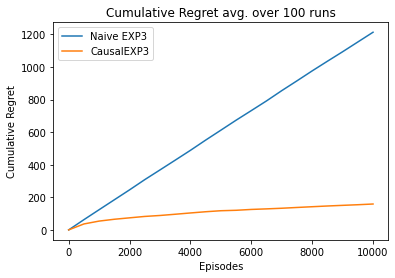

In [ ]:
# Cumulative Regret

T = 10001

# line 1 points
x1 = np.arange(T, step=500)
y1 = np.average(cumulative_regret1,axis=0)
# plotting the line 1 points
plt.plot(x1, y1, label = "Naive EXP3")
 
# line 2 points
x2 = x1
y2 = np.average(cumulative_regret2,axis=0)
# plotting the line 2 points
plt.plot(x2, y2, label = "CausalEXP3")
 
# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Cumulative Regret')
# giving a title to my graph
plt.title('Cumulative Regret avg. over 100 runs')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

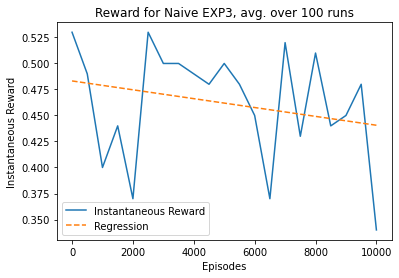

In [ ]:
# Instantaneous Reward for Naive EXP3

T = 10001

# line 1 points
x1 = np.arange(T, step=500)
y1 = np.average(reward1,axis=0)
# plotting the line 1 points
plt.plot(x1, y1, label = "Instantaneous Reward")
# plt.scatter(x1, y1)
m, b = np.polyfit(x1, y1, 1)
plt.plot(x1, m*x1+b, label = "Regression", linestyle='dashed')


# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Instantaneous Reward')
# giving a title to my graph
plt.title('Reward for Naive EXP3, avg. over 100 runs')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

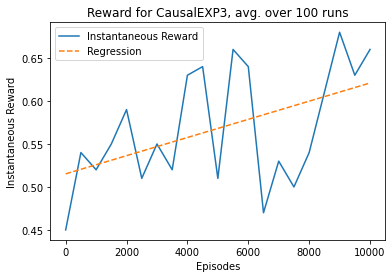

In [ ]:
# Instantaneous Reward for CausalEXP3

T = 10001

# line 1 points
x1 = np.arange(T, step=500)
y1 = np.average(reward2,axis=0)
# plotting the line 1 points
plt.plot(x1, y1, label = "Instantaneous Reward")
# plt.scatter(x1, y1)
m, b = np.polyfit(x1, y1, 1)
plt.plot(x1, m*x1+b, label = "Regression", linestyle='dashed')


# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Instantaneous Reward')
# giving a title to my graph
plt.title('Reward for CausalEXP3, avg. over 100 runs')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()